In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl

import bliss
import bliss.models.galaxy_net
import bliss.datasets.galsim_galaxies

In [2]:
%matplotlib inline

# Create dataset

First we create the dataset containing SDSS galaxies. These galaxies have realistic sizes and fluxes from a catalog, but the morphology is bulge+disk+agn (basically a parametric Sersic mixture) so they are not as realistic as they could be. 

In [3]:
# the catalog we will be using has a sample of 'easiest' (not too small or too faint) galaxies in the catalog.
catalog_file = '../../data/gold_dc2_catalog.fits'

In [4]:
# we prepare a configuration object that is used to create the dataset & model.
from hydra.experimental import initialize, compose
def get_cfg(overrides):
    overrides = [f"{key}={value}" for key, value in overrides.items()]
    with initialize(config_path="../../config"):
        cfg = compose("config", overrides=overrides)
    return cfg

overrides = {
             # dataset information
             'dataset':'sdss_galaxies', 'dataset.cosmoDC2_file': catalog_file,
    
             # model info. 
             'model':'galaxy_net',
    
             # pytorch lightning trainer. 
             'training': 'default'
}
cfg = get_cfg(overrides)
dataset = bliss.datasets.galsim_galaxies.SDSSGalaxies(cfg)

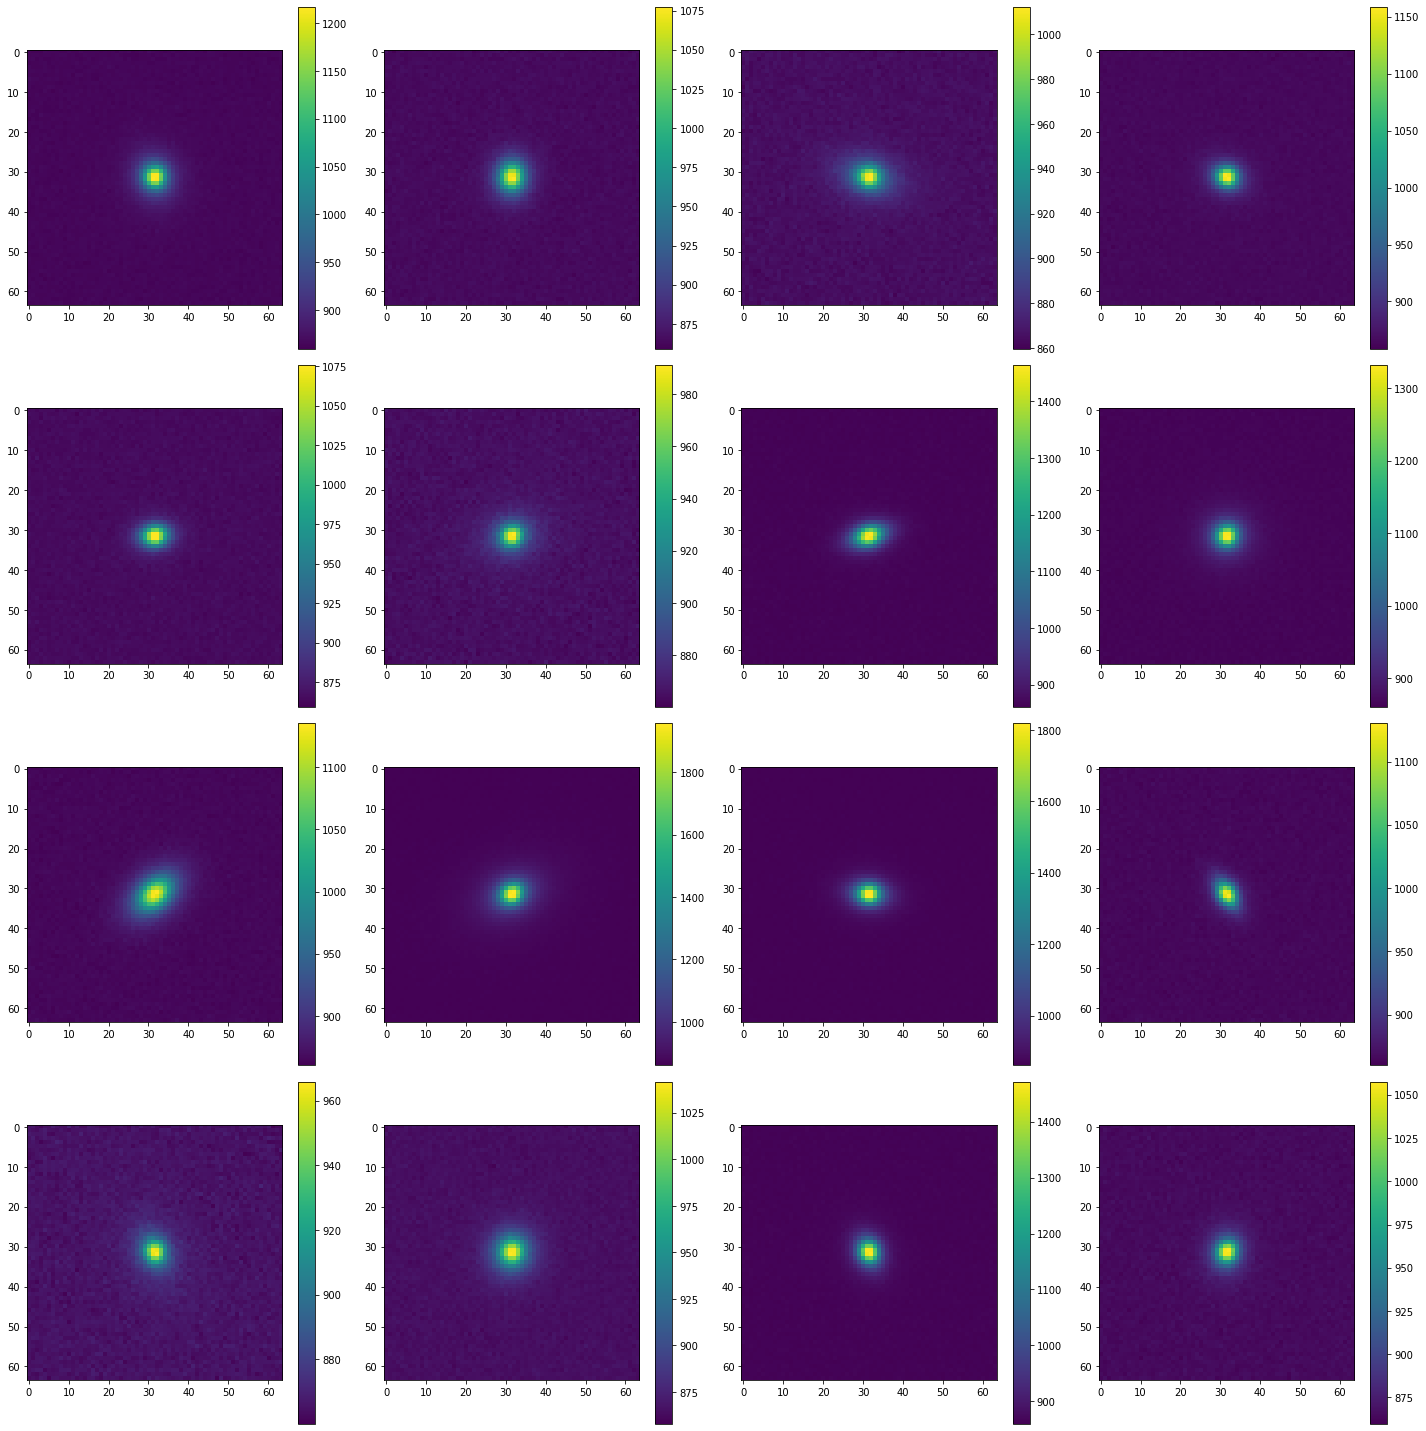

In [5]:
# some example centered individual galaxies from the dataset.
fig, axes = plt.subplots(4,4, figsize=(20, 20))

for ax in axes.flatten():
    idx = np.random.randint(len(dataset.catalog))
    ex = dataset[idx]
    im = ax.imshow(ex['images'][0])
    fig.colorbar(im, ax=ax)

plt.tight_layout()

# Create VAE and Train

The configuration object we created above already contains the model information for our galaxy VAE. 

In [6]:
print(cfg.model)

{'name': 'OneCenteredGalaxy', 'warm_up': 0, 'params': {'slen': 64, 'latent_dim': 8, 'n_bands': 1, 'hidden': 256}}


We can create the VAE directly from this configuration. 

In [7]:
VAE = bliss.models.galaxy_net.OneCenteredGalaxy(cfg)

In [9]:
VAE

OneCenteredGalaxy(
  (enc): CenteredGalaxyEncoder(
    (features): Sequential(
      (0): BatchNorm2d(1, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
      (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (8): ReLU()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (10): ReLU()
      (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (12): ReLU()
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU()
      (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (16): ReLU()
      (17): Flatten(start_dim=1, end_dim=-1)
      (18): Linear(in_feature

And we also need a trainer to train. 

In [10]:
# create trainer
n_epochs = 101
trainer = pl.Trainer(profiler=None, logger=False, checkpoint_callback=False, 
                     max_epochs=n_epochs, min_epochs=n_epochs, 
                     gpus=[2], check_val_every_n_epoch=1001,)


# train! 
trainer.fit(VAE, datamodule=dataset)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


KeyboardInterrupt: 

# Compare results

Now that our model is trained we can compare some results. 

In [ ]:
import torch
VAE.eval()

# example reconstruction
# some example centered individual galaxies from the dataset.
fig, axes = plt.subplots(5,2, figsize=(10, 24))

#always different.
for b in dataset.train_dataloader():
    batch = b
    break

recon_mean, recon_var, _ = VAE(batch['images'],batch['background'])

for i, (ax1, ax2) in enumerate(axes):
    
    # plot
    im1 = ax1.imshow(batch['images'][i][0])
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(recon_mean[i][0].detach().numpy())
    fig.colorbar(im2, ax=ax2)
plt.tight_layout()

In [11]:
import torch
z = torch.randn(10, 1, 64, 64).to('cuda:4')
VAE = VAE.to('cuda:4')

In [13]:
z1, z2 = VAE.enc.forward(z)
print(z1.shape, z2.shape)

torch.Size([10, 8]) torch.Size([10, 8])


In [14]:
mu, var = VAE.dec.forward(z1)
print(mu.shape, var.shape)

torch.Size([10, 1, 64, 64]) torch.Size([10, 1, 64, 64])
